In [1]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    os.chdir("../")
    print("Working on local machine...")

Working on local machine...


In [2]:
# !pip install -r requirements.txt

In [3]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled = False
    return True

In [5]:
set_seed(42)

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available! Using CPU!")

No GPU available! Using CPU!


In [6]:
# Custom dataset to handle image and target loading
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

In [7]:
full_data = np.load("./data/processed/SP500.EURUSD.USTREASURYINDEX.2014.2023/data.npy", allow_pickle=True)   # noqa
print(full_data.shape)
data = full_data[:400]
# data = full_data
print(data[:1, :])

(2350, 4)
[[array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8) -1.0 0.44467162365062535
  0.5553283763493746]]


In [8]:
def train_val_test_split(data, train_size=0.7, val_size=0.2):
    train_size = int(len(data) * train_size)
    val_size = int(len(data) * val_size)
    test_size = len(data) - train_size - val_size
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data

In [9]:
train_data, val_data, test_data = train_val_test_split(data)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

train_images = train_data[:, 0]
train_targets = np.asarray(train_data[:, 1:], dtype=np.float32)

val_images = val_data[:, 0]
val_targets = np.asarray(val_data[:, 1:], dtype=np.float32)

test_images = test_data[:, 0]
test_targets = np.asarray(test_data[:, 1:], dtype=np.float32)

print(train_images[0])
print(train_targets[0])

(280, 4)
(80, 4)
(40, 4)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[-1.          0.44467163  0.55532837]


In [10]:
# Transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Create datasets and dataloaders
trainset = ImageDataset(train_images, train_targets, transform=transform)
valset = ImageDataset(val_images, val_targets, transform=transform)
testset = ImageDataset(test_images, test_targets, transform=transform)

trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
valloader = DataLoader(valset, batch_size=8, shuffle=False)
testloader = DataLoader(testset, batch_size=8, shuffle=False)

In [11]:
class Net(nn.Module):
    def __init__(self, leak=0.2, output_size=3, img_size=64):
        super(Net, self).__init__()
        self.img_size = img_size

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(128, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.leakyrelu = nn.LeakyReLU(negative_slope=leak)
        self.flatten = nn.Flatten()

        # Compute the size of the flattened feature map after the convolutional layers
        self.feature_dim = self._calculate_feature_dim()

        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_dim, 128)
        self.fc2 = nn.Linear(128, output_size)

    def _calculate_feature_dim(self):
        # Function to calculate the size of the feature map after all convolutional and pooling layers
        size = self.img_size
        size = self._conv_output_size(size, kernel_size=3, padding=1)  # conv1
        size = self.pool_output_size(size, kernel_size=2)  # pool1
        size = self._conv_output_size(size, kernel_size=3, padding=1)  # conv2
        size = self.pool_output_size(size, kernel_size=2)  # pool2
        size = self._conv_output_size(size, kernel_size=3, padding=1)  # conv3
        size = self._conv_output_size(size, kernel_size=3, padding=1)  # conv4
        size = self.pool_output_size(size, kernel_size=2)  # pool3
        size = self._conv_output_size(size, kernel_size=3, padding=1)  # conv9
        size = self.pool_output_size(size, kernel_size=2)  # pool4

        return 16 * size * size

    def _conv_output_size(self, input_size, kernel_size, stride=1, padding=0):
        return (input_size + 2 * padding - kernel_size) // stride + 1

    def pool_output_size(self, input_size, kernel_size, stride=2):
        return input_size // kernel_size

    def forward(self, xb):
        # Convolution layers
        xb = self.leakyrelu(self.conv1(xb))
        xb = self.pool(xb)
        xb = self.leakyrelu(self.conv2(xb))
        xb = self.pool(xb)
        xb = self.leakyrelu(self.conv3(xb))
        xb = self.leakyrelu(self.conv4(xb))
        xb = self.leakyrelu(self.conv5(xb))
        xb = self.leakyrelu(self.conv6(xb))
        xb = self.leakyrelu(self.conv7(xb))
        xb = self.pool(xb)
        xb = self.leakyrelu(self.conv9(xb))
        xb = self.pool(xb)

        # Flatten the output for the fully connected layers
        xb = self.flatten(xb)

        # Fully connected layers
        xb = self.leakyrelu(self.fc1(xb))
        xb = self.fc2(xb)
        return xb


In [12]:
class CustomLoss(nn.Module):
    def __init__(self, loss_function=nn.MSELoss()):
        super(CustomLoss, self).__init__()
        self.element_loss = loss_function

    def forward(self, outputs, targets):
        loss = self.element_loss(outputs, targets)
        sum_penalty = torch.mean(torch.abs(torch.sum(outputs, dim=1)))
        return loss + sum_penalty

In [13]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

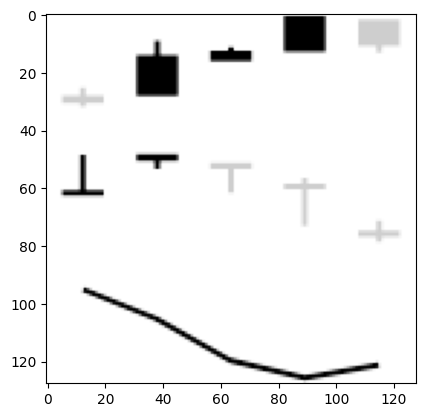

In [14]:
# get some random training images
images, labels = trainloader.dataset[0]

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

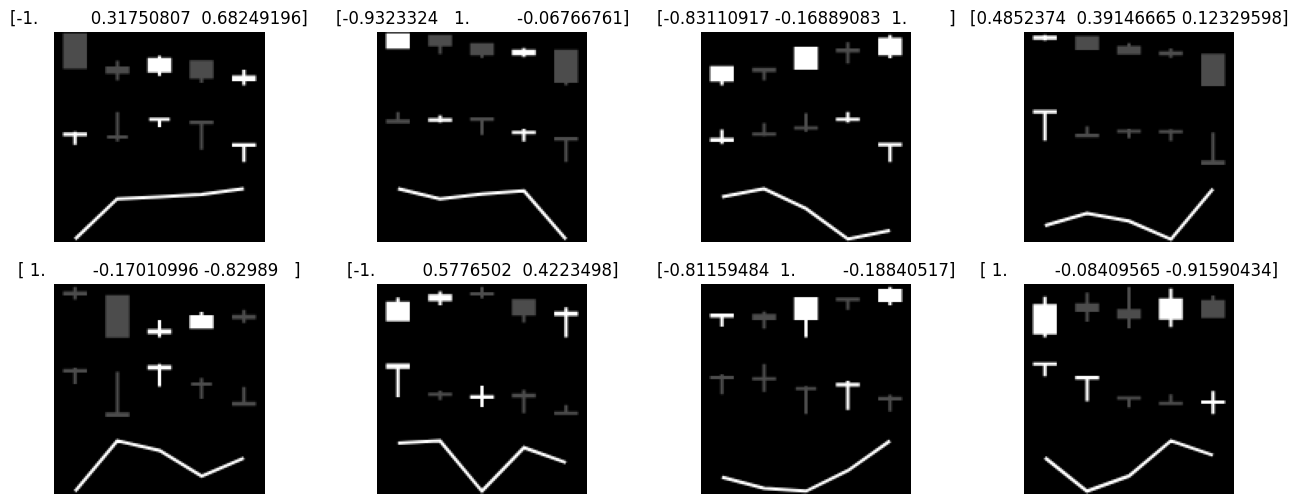

In [15]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.images, trainset.targets)

# plot images
plt.figure(figsize=(16, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

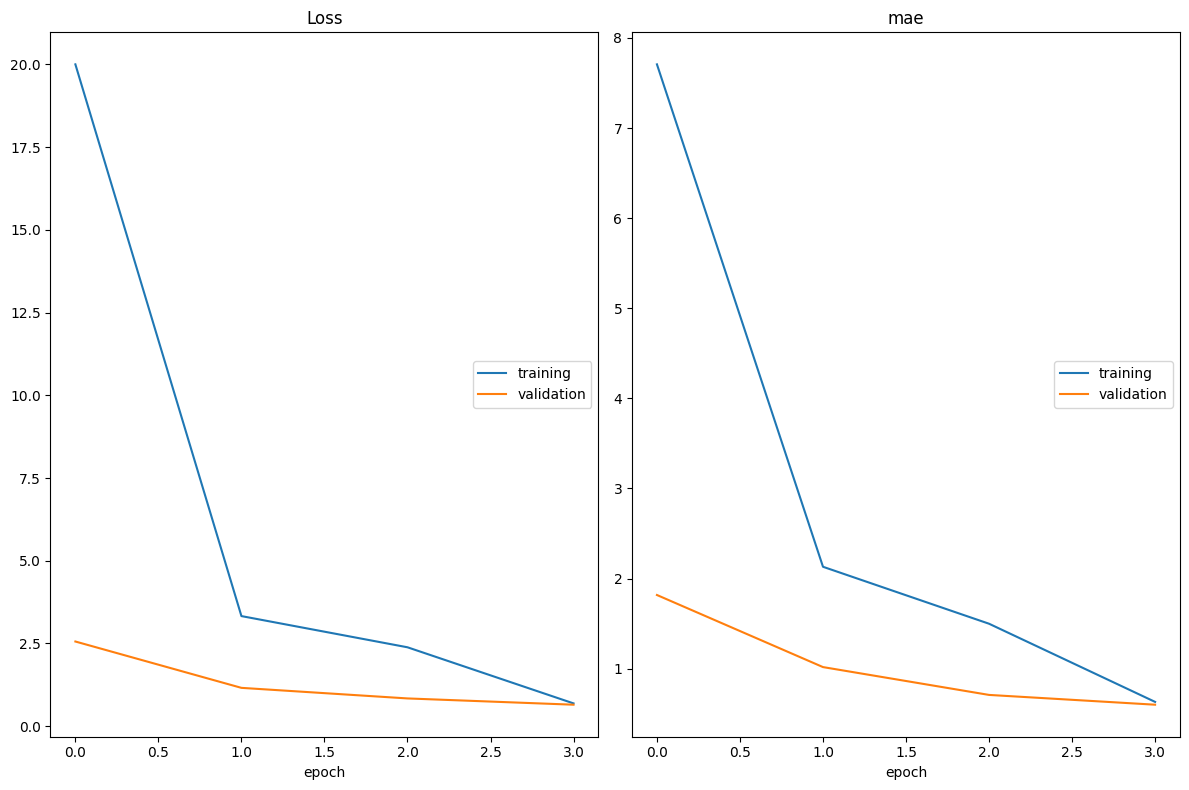

Loss
	training         	 (min:    0.689, max:   20.004, cur:    0.689)
	validation       	 (min:    0.649, max:    2.559, cur:    0.649)
mae
	training         	 (min:    0.631, max:    7.707, cur:    0.631)
	validation       	 (min:    0.600, max:    1.817, cur:    0.600)
Epoch 4/30, Train Loss: 0.6887, Train MAE: 0.6309, Validation Loss: 0.6492, Validation MAE: 0.5997


KeyboardInterrupt: 

In [16]:
# Initialize the model, loss function, and optimizer
model = Net(img_size=128).to(device)
criterion = CustomLoss(nn.L1Loss())
optimizer = optim.AdamW(model.parameters(), lr=0.003)

def mean_absolute_error(pred, target):
    return torch.mean(torch.abs(pred - target))

epochs = 30
best_val_loss = float('inf')
liveloss = PlotLosses()

for epoch in range(epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for images, targets in trainloader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_mae += mean_absolute_error(outputs, targets).item() * images.size(0)

    train_loss = running_loss / len(trainloader.dataset)
    train_mae = running_mae / len(trainloader.dataset)
    logs['loss'] = train_loss
    logs['mae'] = train_mae

    # Validation
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for images, targets in valloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            val_mae += mean_absolute_error(outputs, targets).item() * images.size(0)

    val_loss = val_loss / len(valloader.dataset)
    val_mae = val_mae / len(valloader.dataset)
    logs['val_loss'] = val_loss
    logs['val_mae'] = val_mae

    liveloss.update(logs)
    liveloss.send()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './deep_learning/models/best_model.pth')

print('Finished Training')


In [ ]:
# Load the best model
model.load_state_dict(torch.load('./deep_learning/models/best_model.pth'))

# Example of testing the model with a new image
test_image = full_data[500, 0]
test_image_tensor = transform(test_image).unsqueeze(0)  # Add batch dimension

model.eval()
with torch.no_grad():
    prediction = model(test_image_tensor)
    print("Predicted values:", prediction.numpy())

print("Actual values:", full_data[500, 1:])
